## (Project name)

### Group member: Elaine Zhang, Xintong Zheng, Xi Yan

Description:

In [8]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')

In [9]:
# Import ML packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.datasets import load_credit
from yellowbrick.datasets import load_hobbies
from sklearn.datasets import make_blobs

### Read and clean weather data
The weather data is retrieved from [National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/search), ranged from Jan.1 2017 to Dec.31 2019, of a weather station located at Pittsburgh, PA, USA.

In [10]:
# Read weather csv file
weather = pd.read_csv("pit_weather.csv")
# Select only 5 columns from the initial dataset
weather = weather[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN']]
# Calculate the average temperature of the day
weather['TAVG'] = weather[['TMAX', 'TMIN']].mean(axis=1)
# Show if there are any missing values
weather.info()
# However, we will not drop the NaN values now for the convenience of merging dataset
weather.isnull().sum(axis=0)
# Print the first 5 rows of the dataset
weather.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1095 non-null   object 
 1   AWND    1092 non-null   float64
 2   PRCP    1094 non-null   float64
 3   TMAX    1093 non-null   float64
 4   TMIN    1093 non-null   float64
 5   TAVG    1093 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.5+ KB


,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,2017-01-02,7.16,0.09,46.0,36.0,41.0
2,2017-01-03,6.93,0.76,50.0,42.0,46.0
3,2017-01-04,15.66,0.04,45.0,21.0,33.0
4,2017-01-05,8.72,0.06,23.0,18.0,20.5


### Read and clean ride rentals data
The ride rental data is retrieved from [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/healthyride-trip-data), since we are using 2017-2019 data, and the data is a .csv file quarterly. We have to combine 12 .csv data first in order to finish the cleaning.

In [11]:
ride = pd.DataFrame(data = None)
for i in range(7,10):
    for j in range(1,5):
        ride_1 = pd.read_csv("healthy-ride-rentals-201{}-q{}.csv".format(i, j))
        # drop the lines with NA
        ride_1 = ride_1.dropna(axis=0)
        # copy the column with date
        ride_1["tmp"] = ride_1["Starttime"]
        # starttime and stoptime delete the date
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: str(x).split(" ")[1])
        # convert starttime to minutes
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: str(x).split(" ")[1])
        # convert stoptime to minutes
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        # extract date to a new column and then merge with weather dataset
        ride_1["DATE"] = ride_1["tmp"].apply(lambda x: str(str(x).split("/")[2]).split(" ")[0] + "-" + str(x).split("/")[0]+ "-"  + str(x).split("/")[1])
        # adjust the format
        ride_1["DATE"] = pd.to_datetime(ride_1["DATE"]).apply(lambda x: str(x).split(" ")[0])
        # delete the temp column
        del ride_1["tmp"]

        # add each subdataset
        ride = pd.concat([ride, ride_1])
ride

C:\Users\Elaine\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,DATE
0,25723960.0,508,510,70478.0,110.0,1043.0,S Millvale Ave & Centre Ave,1044.0,Zulema St & Coltart Ave,Subscriber,2017-01-01
1,25724207.0,593,600,70439.0,426.0,1014.0,Ridge Ave & Brighton Rd (CCAC),1012.0,North Shore Trail & Fort Duquesne Bridge,Customer,2017-01-01
2,25724297.0,621,646,70440.0,1498.0,1019.0,42nd St & Butler St,1012.0,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017-01-01
3,25724391.0,663,690,70002.0,1581.0,1019.0,42nd St & Butler St,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
4,25724479.0,703,729,70024.0,1563.0,1018.0,Butler St & Stanton Ave,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...
19850,89029487.0,1003,1009,70340.0,347.0,1023.0,Liberty Ave & Baum Blvd,1043.0,S Millvale Ave & Centre Ave,Subscriber,2019-11-02
19851,89029593.0,1007,1011,70277.0,242.0,1018.0,Butler St & Stanton Ave,1019.0,42nd St & Butler St,Subscriber,2019-11-02
19852,89029810.0,1016,1048,70153.0,1952.0,1093.0,S Bouquet Ave & Sennott St,1036.0,Schenley Dr at Schenley Plaza (Carnegie Librar...,Customer,2019-11-02
19853,89031027.0,1061,1069,70536.0,479.0,1063.0,Penn Ave & N Atlantic Ave,49401.0,Stanton Ave & N Negley Ave,Subscriber,2019-11-02


In [12]:
# Merge ride dataframe with weather dataframe based on DATE
df_merged = pd.merge(ride, weather, on='DATE')
df_merged.info()
# Show how many rows have empty values
df_merged.isnull().sum(axis=0)
# Drop rows which contain NaN values
df_merged = df_merged.dropna()
# Drop not useful columns
df_merged = df_merged.drop(['Trip id', 'Bikeid','From station name', 'To station name'], axis=1)
# Convert Usertype from categorical to dummy variable 0(customer) and 1(subscriber)
df_merged['Usertype'] = df_merged['Usertype'].astype('category').cat.codes
# Show top 5 rows of the dataset
df_merged.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 227290 entries, 0 to 227289
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Trip id            227290 non-null  float64
 1   Starttime          227290 non-null  int64  
 2   Stoptime           227290 non-null  int64  
 3   Bikeid             227290 non-null  float64
 4   Tripduration       227290 non-null  float64
 5   From station id    227290 non-null  float64
 6   From station name  227290 non-null  object 
 7   To station id      227290 non-null  float64
 8   To station name    227290 non-null  object 
 9   Usertype           227290 non-null  object 
 10  DATE               227290 non-null  object 
 11  AWND               227006 non-null  float64
 12  PRCP               226736 non-null  float64
 13  TMAX               227215 non-null  float64
 14  TMIN               227215 non-null  float64
 15  TAVG               227215 non-null  float64
dtypes:

,Starttime,Stoptime,Tripduration,From station id,To station id,Usertype,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,508,510,110.0,1043.0,1044.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,593,600,426.0,1014.0,1012.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
2,621,646,1498.0,1019.0,1012.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
3,663,690,1581.0,1019.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
4,703,729,1563.0,1018.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0


Start from here!!!!!!!!!!!!!!!

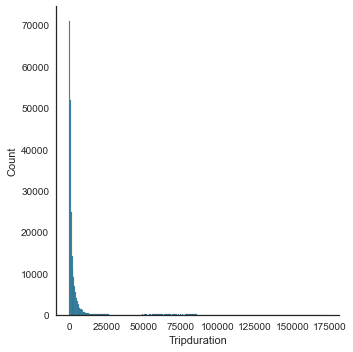

In [13]:
df_q1 = df_merged
# show the distribution of duration
# This plot tries to see the distribution of Usertype for ride rentals
sns.displot(df_q1['Tripduration'], bins = 300)

<Figure size 864x432 with 0 Axes>

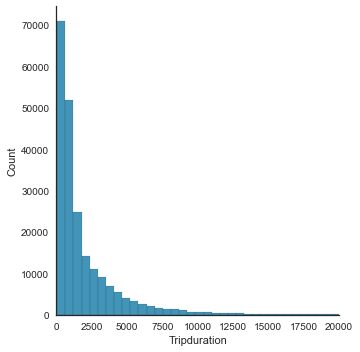

In [14]:
# zoom in the most hense area to select the general proper step size
plt.figure(figsize = (12, 6))
sns.displot(df_q1['Tripduration'], bins = 300)
plt.xlim(0, 20000)
plt.show()

As is shown in the figure, the distribution is highly skewed and most of the users ride within 2500 seconds. It is not proper to have a very large step size, thus most of the data will fall into one class.
So we can split the duration into 5 classes with the 3 step sizes: 600, 900, and 1200

In [15]:
# categorize trip duration into 5 classes
# the function is to test the best stepsize for 5 classes
def cat_type(x, stepsize):
    if x <= stepsize:
        a='1'
    elif x > stepsize and x <= stepsize * 2:
        a='2'
    elif x > stepsize * 2 and x <= stepsize * 3:
        a='3'
    elif x > stepsize * 3 and x <= stepsize * 4:
        a='4'
    else:
        a='5'
    return a

Model 1: KNN

Time interval for duration is: 600 seconds
              precision    recall  f1-score   support

           1      0.874     0.928     0.900     19797
           2      0.831     0.819     0.825     16831
           3      0.821     0.791     0.806      7752
           4      0.838     0.750     0.792      4433
           5      0.986     0.974     0.980     19123

    accuracy                          0.887     67936
   macro avg      0.870     0.852     0.861     67936
weighted avg      0.887     0.887     0.886     67936



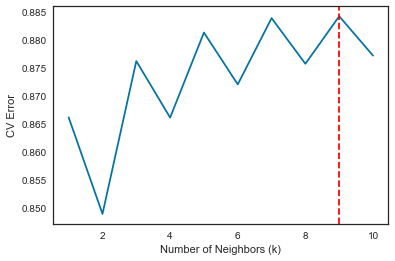

              precision    recall  f1-score   support

           1      0.869     0.940     0.903     19797
           2      0.834     0.819     0.826     16831
           3      0.824     0.780     0.801      7752
           4      0.857     0.742     0.796      4433
           5      0.988     0.973     0.981     19123

    accuracy                          0.888     67936
   macro avg      0.875     0.851     0.861     67936
weighted avg      0.888     0.888     0.887     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
              precision    recall  f1-score   support

           1      0.935     0.978     0.956     30155
           2      0.889     0.843     0.866     14225
           3      0.883     0.830     0.856      6203
           4      0.871     0.863     0.867      4403
           5      0.984     0.966     0.975     12950

    accuracy                          0.927     67936
   macro avg

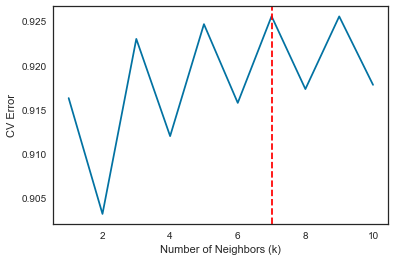

              precision    recall  f1-score   support

           1      0.933     0.984     0.957     30155
           2      0.898     0.840     0.868     14225
           3      0.892     0.829     0.859      6203
           4      0.876     0.869     0.872      4403
           5      0.986     0.966     0.976     12950

    accuracy                          0.929     67936
   macro avg      0.917     0.898     0.907     67936
weighted avg      0.928     0.929     0.928     67936

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
              precision    recall  f1-score   support

           1      0.963     0.987     0.975     36628
           2      0.922     0.873     0.897     12185
           3      0.904     0.902     0.903      6173
           4      0.889     0.886     0.887      3757
           5      0.987     0.962     0.974      9193

    accuracy                          0.950     67936
   macro av

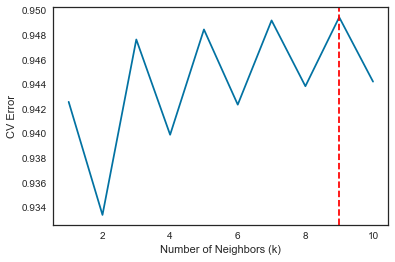

              precision    recall  f1-score   support

           1      0.959     0.991     0.975     36628
           2      0.931     0.865     0.897     12185
           3      0.909     0.909     0.909      6173
           4      0.903     0.881     0.892      3757
           5      0.988     0.961     0.974      9193

    accuracy                          0.950     67936
   macro avg      0.938     0.921     0.929     67936
weighted avg      0.950     0.950     0.950     67936

---------------------------------------------------------------------------


In [53]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # KNN for duration category
    knn_q1 = KNeighborsClassifier().fit(X_train_q1, y_train_q1)
    y_pred_q1 = knn_q1.predict(X_test_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    print(classification_report(y_test_q1, y_pred_q1, digits=3))
    
    # tune the model and try number of neighbors from 1 to 10
    neighbors = range(1, 11)
    knn_scores = []
    for i in neighbors:
        knn_q1 = KNeighborsClassifier(n_neighbors=i)
        CV_error = np.mean(cross_val_score(knn_q1, X_train_q1, y_train_q1, cv=10, scoring = 'accuracy'))
        knn_scores.append(CV_error)

    # plot the trend of k
    plt.plot(neighbors,knn_scores)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("CV Error")
    plt.axvline(x=neighbors[knn_scores.index(max(knn_scores))],linestyle='--',color="red")
    plt.show()
    
    # show the result of tuned model
    knn = KNeighborsClassifier(n_neighbors=neighbors[knn_scores.index(max(knn_scores))]).fit(X_train_q1, y_train_q1)
    y_pred_q1 = knn.predict(X_test_q1)
    print(classification_report(y_test_q1, y_pred_q1, digits=3))
    print("---------------------------------------------------------------------------")

The general results of KNN are very well, with the average accuracy around 0.9.
When we tune the model, the accuracy gets improved except the one with step size = 1200s, maybe because the accuracy of 0.95 is too high to improve.

Model 2: Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

In [52]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # Naive Bayes
    modelNB = GaussianNB().fit(X_train_q1, y_train_q1)
    y_pred_q1 = modelNB.predict(X_test_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    print(classification_report(y_test_q1, y_pred_q1, digits=3, zero_division=1))
    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
              precision    recall  f1-score   support

           1      0.450     0.568     0.502     19797
           2      0.315     0.220     0.259     16831
           3      0.182     0.003     0.006      7752
           4      1.000     0.000     0.000      4433
           5      0.487     0.790     0.603     19123

    accuracy                          0.443     67936
   macro avg      0.487     0.316     0.274     67936
weighted avg      0.432     0.443     0.381     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
              precision    recall  f1-score   support

           1      0.630     0.788     0.700     30155
           2      0.233     0.012     0.023     14225
           3      1.000     0.000     0.000      6203
           4      1.000     0.000     0.000      4403
           5      0.337     0.767     0.468     12950

    accuracy           

The performances of Naive Bayes are very bad. The best of them is 0.522. 
So Naive Bayes is not a good model for this problem.

Model 3: DecisionTree

In [16]:
import plotly.express as px
import pydot
import graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from dtreeviz.trees import dtreeviz
#from dtreeviz.trees import *
from sklearn.datasets import load_wine

%matplotlib inline
plt.style.use('seaborn-white')

Time interval for duration is: 600 seconds
Mean CV score of 0.29, with a standard deviation of 0.01
Mean CV score of -1.81, with a standard deviation of 0.01
Accuracy of test dataset is: 0.29637245144389157


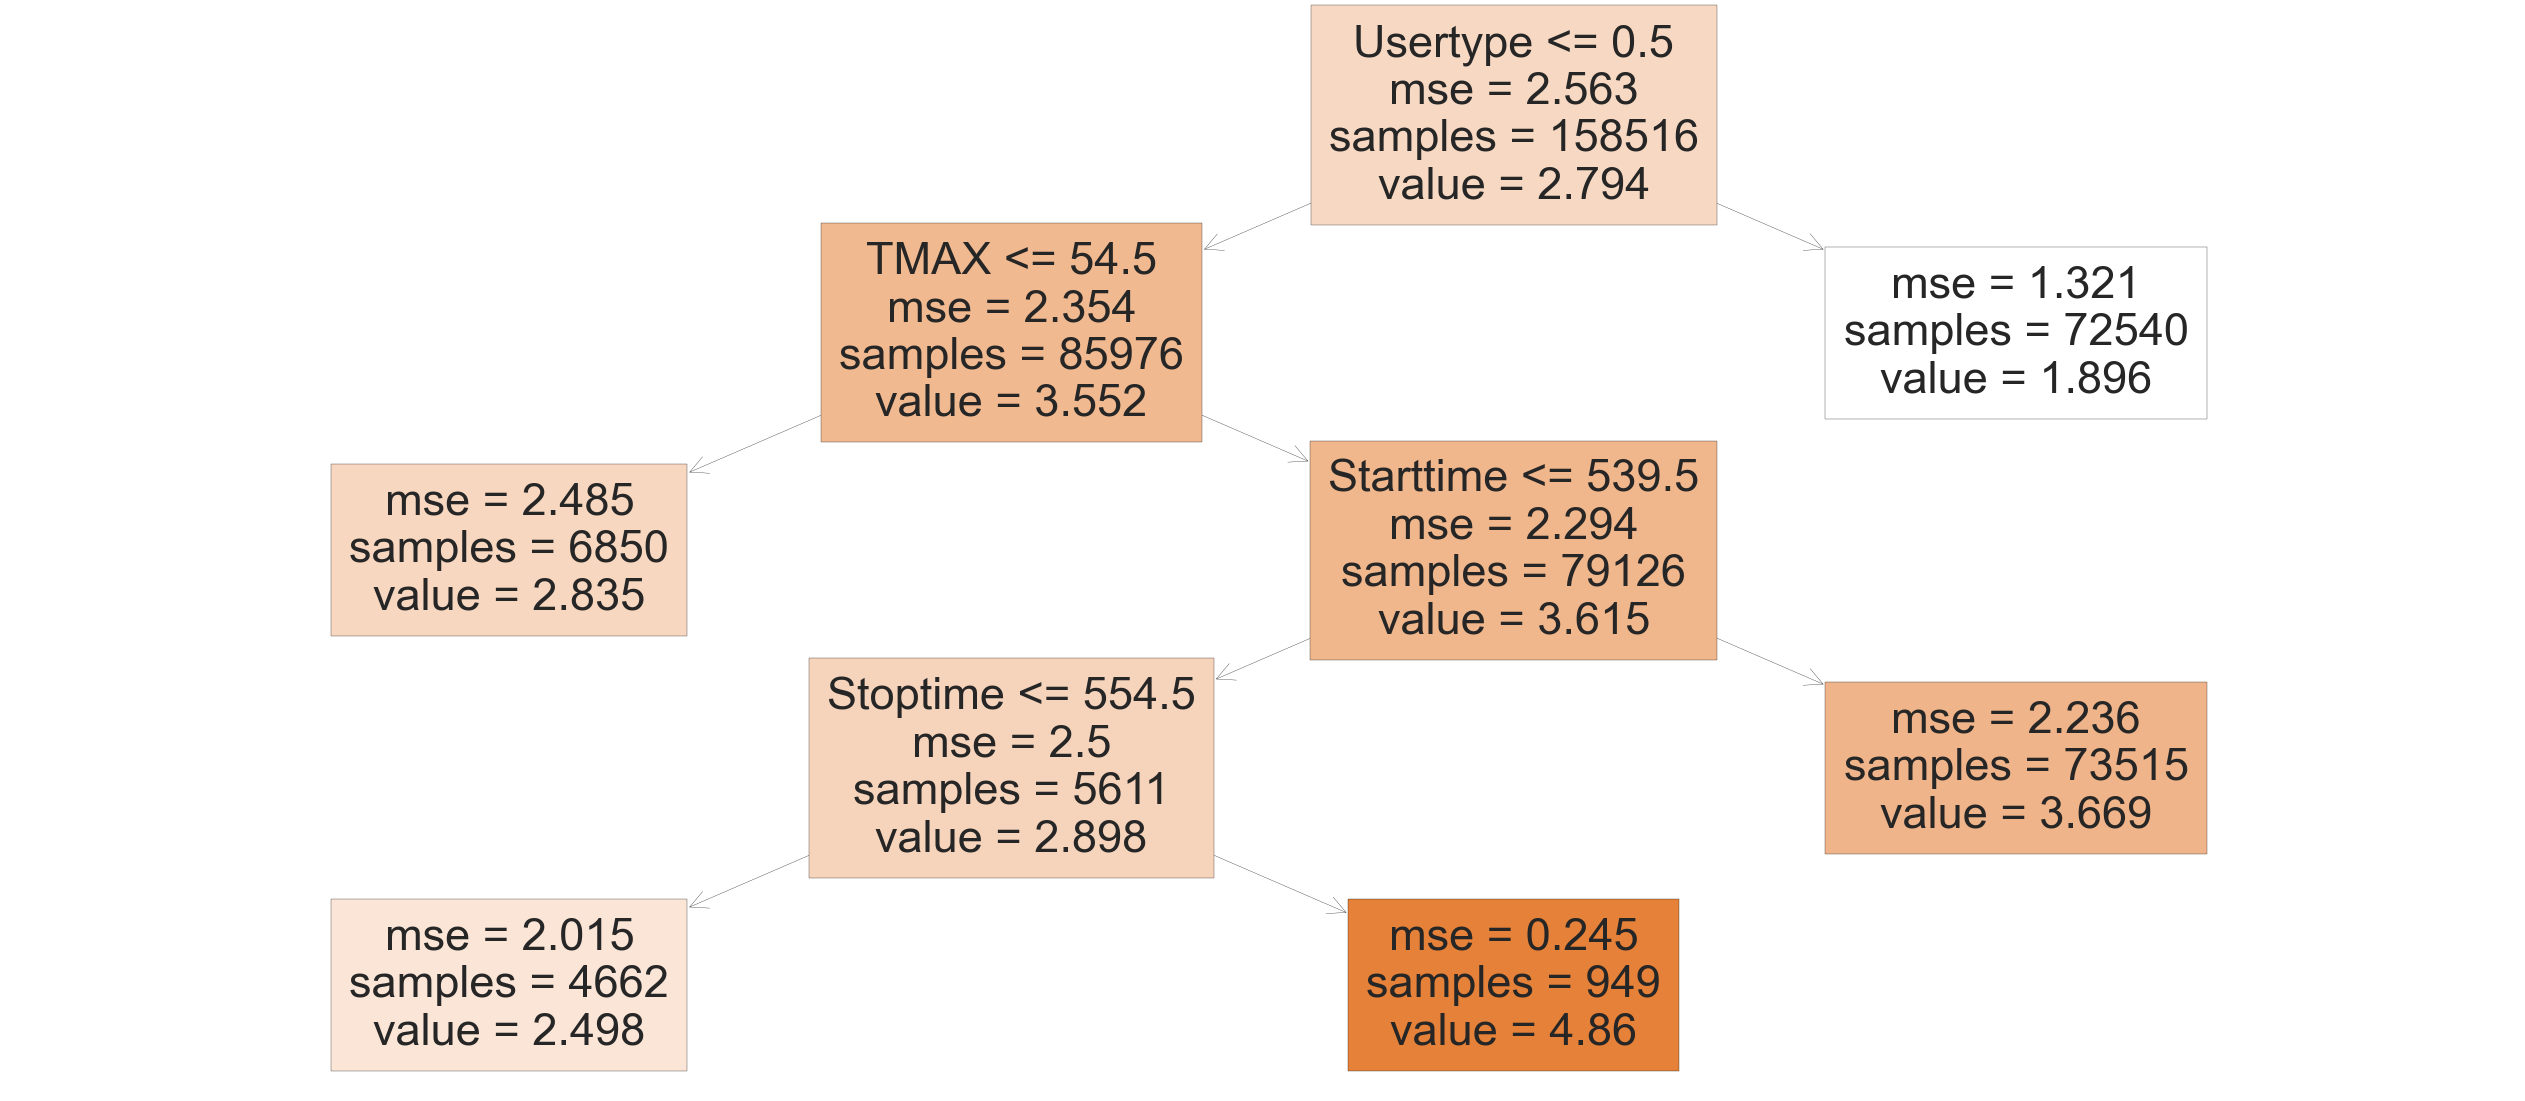

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
Mean CV score of 0.27, with a standard deviation of 0.01
Mean CV score of -1.74, with a standard deviation of 0.01
Accuracy of test dataset is: 0.275413772840744


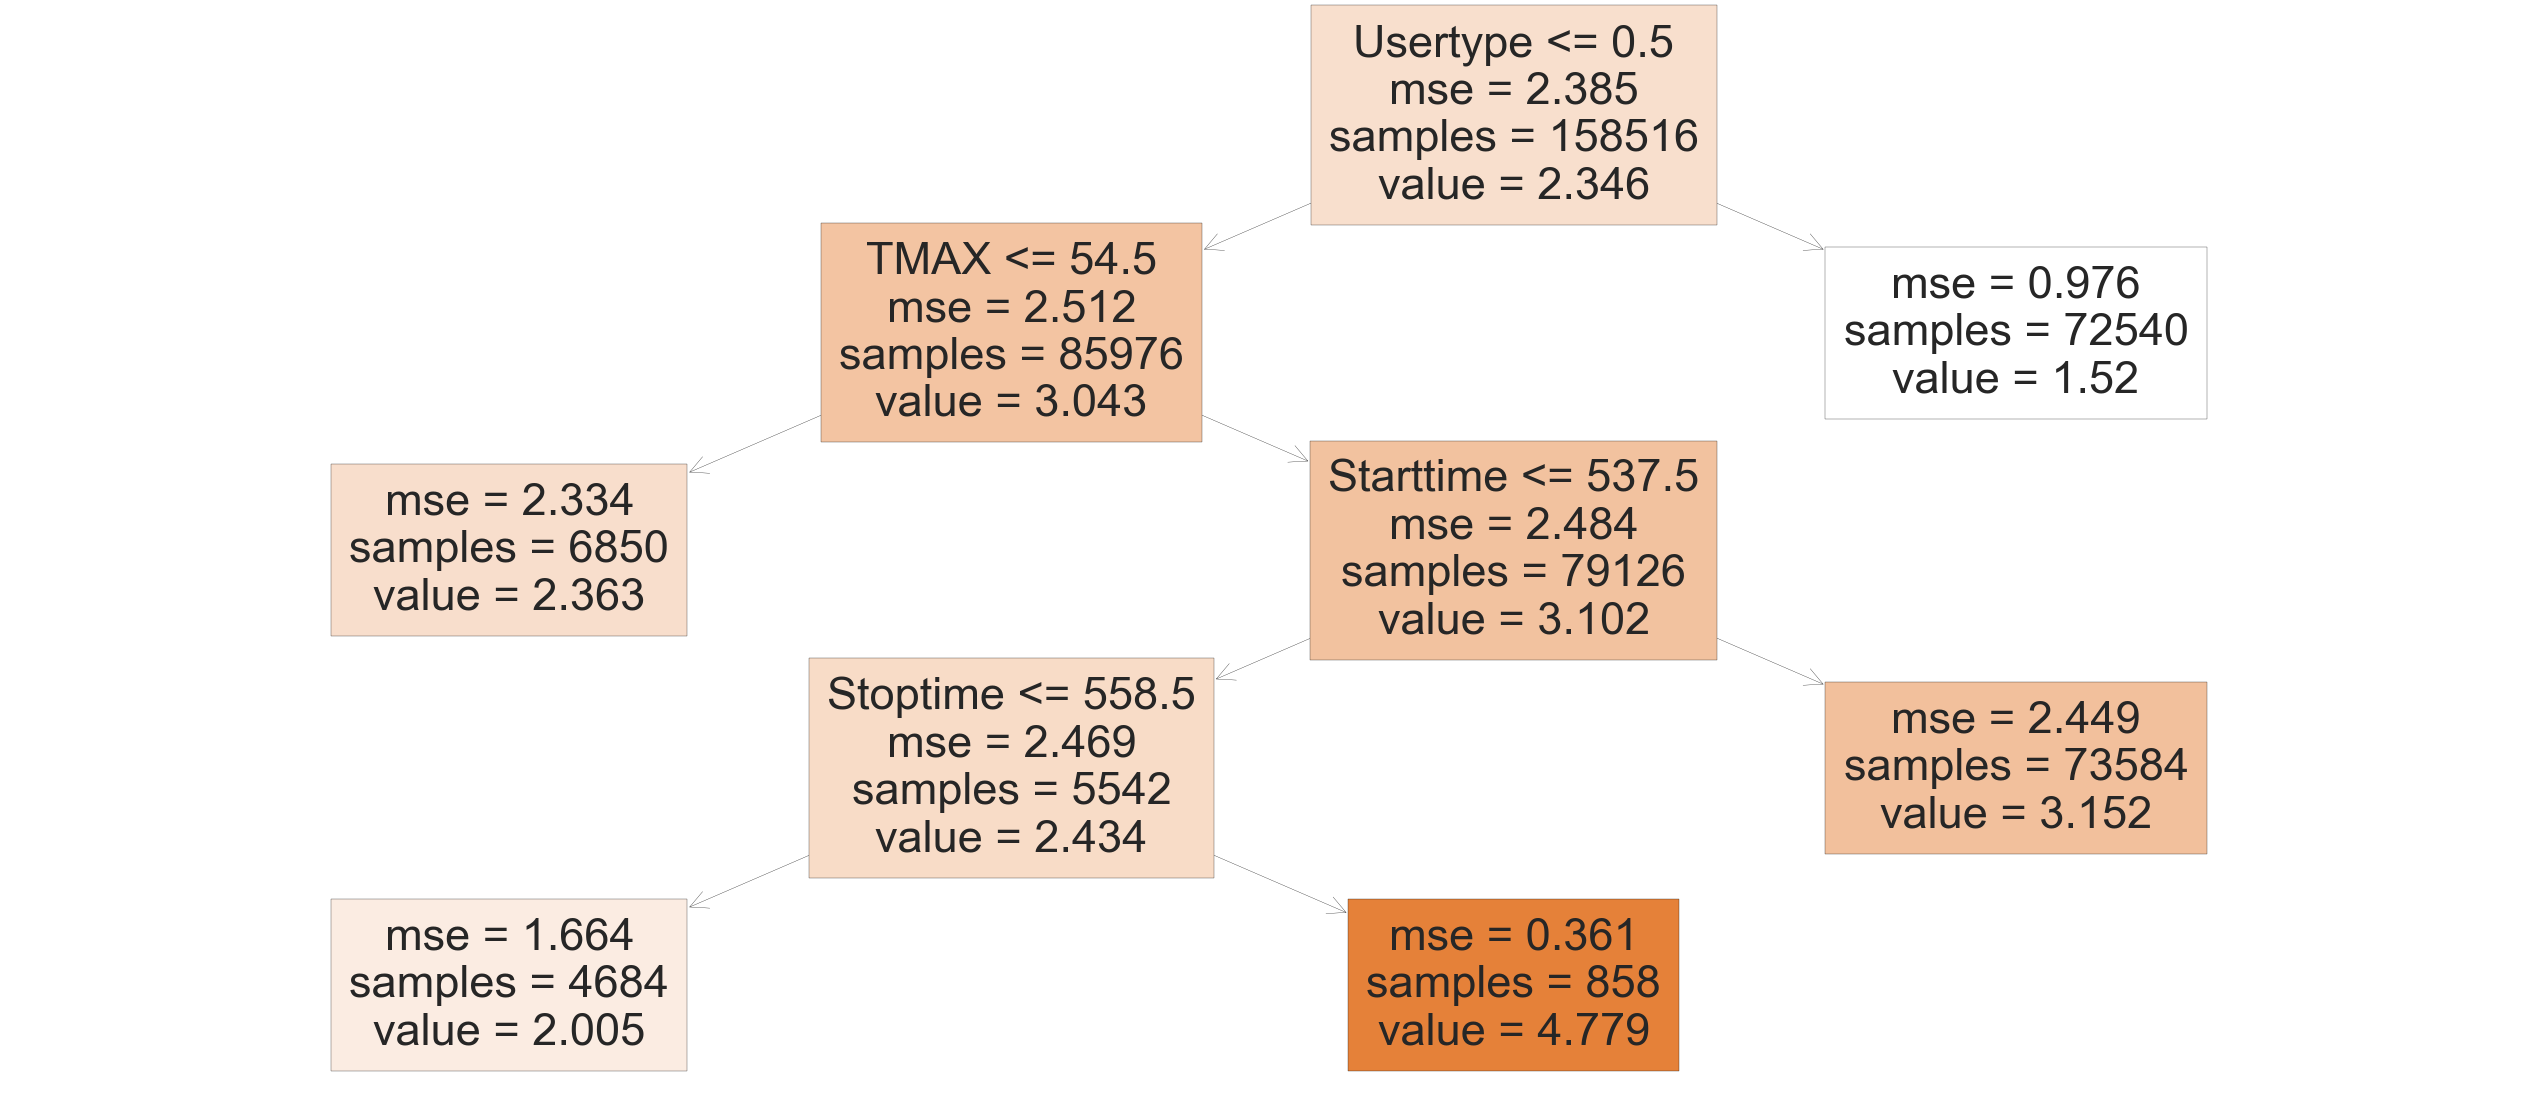

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
Mean CV score of 0.24, with a standard deviation of 0.01
Mean CV score of -1.57, with a standard deviation of 0.01
Accuracy of test dataset is: 0.24423678800735046


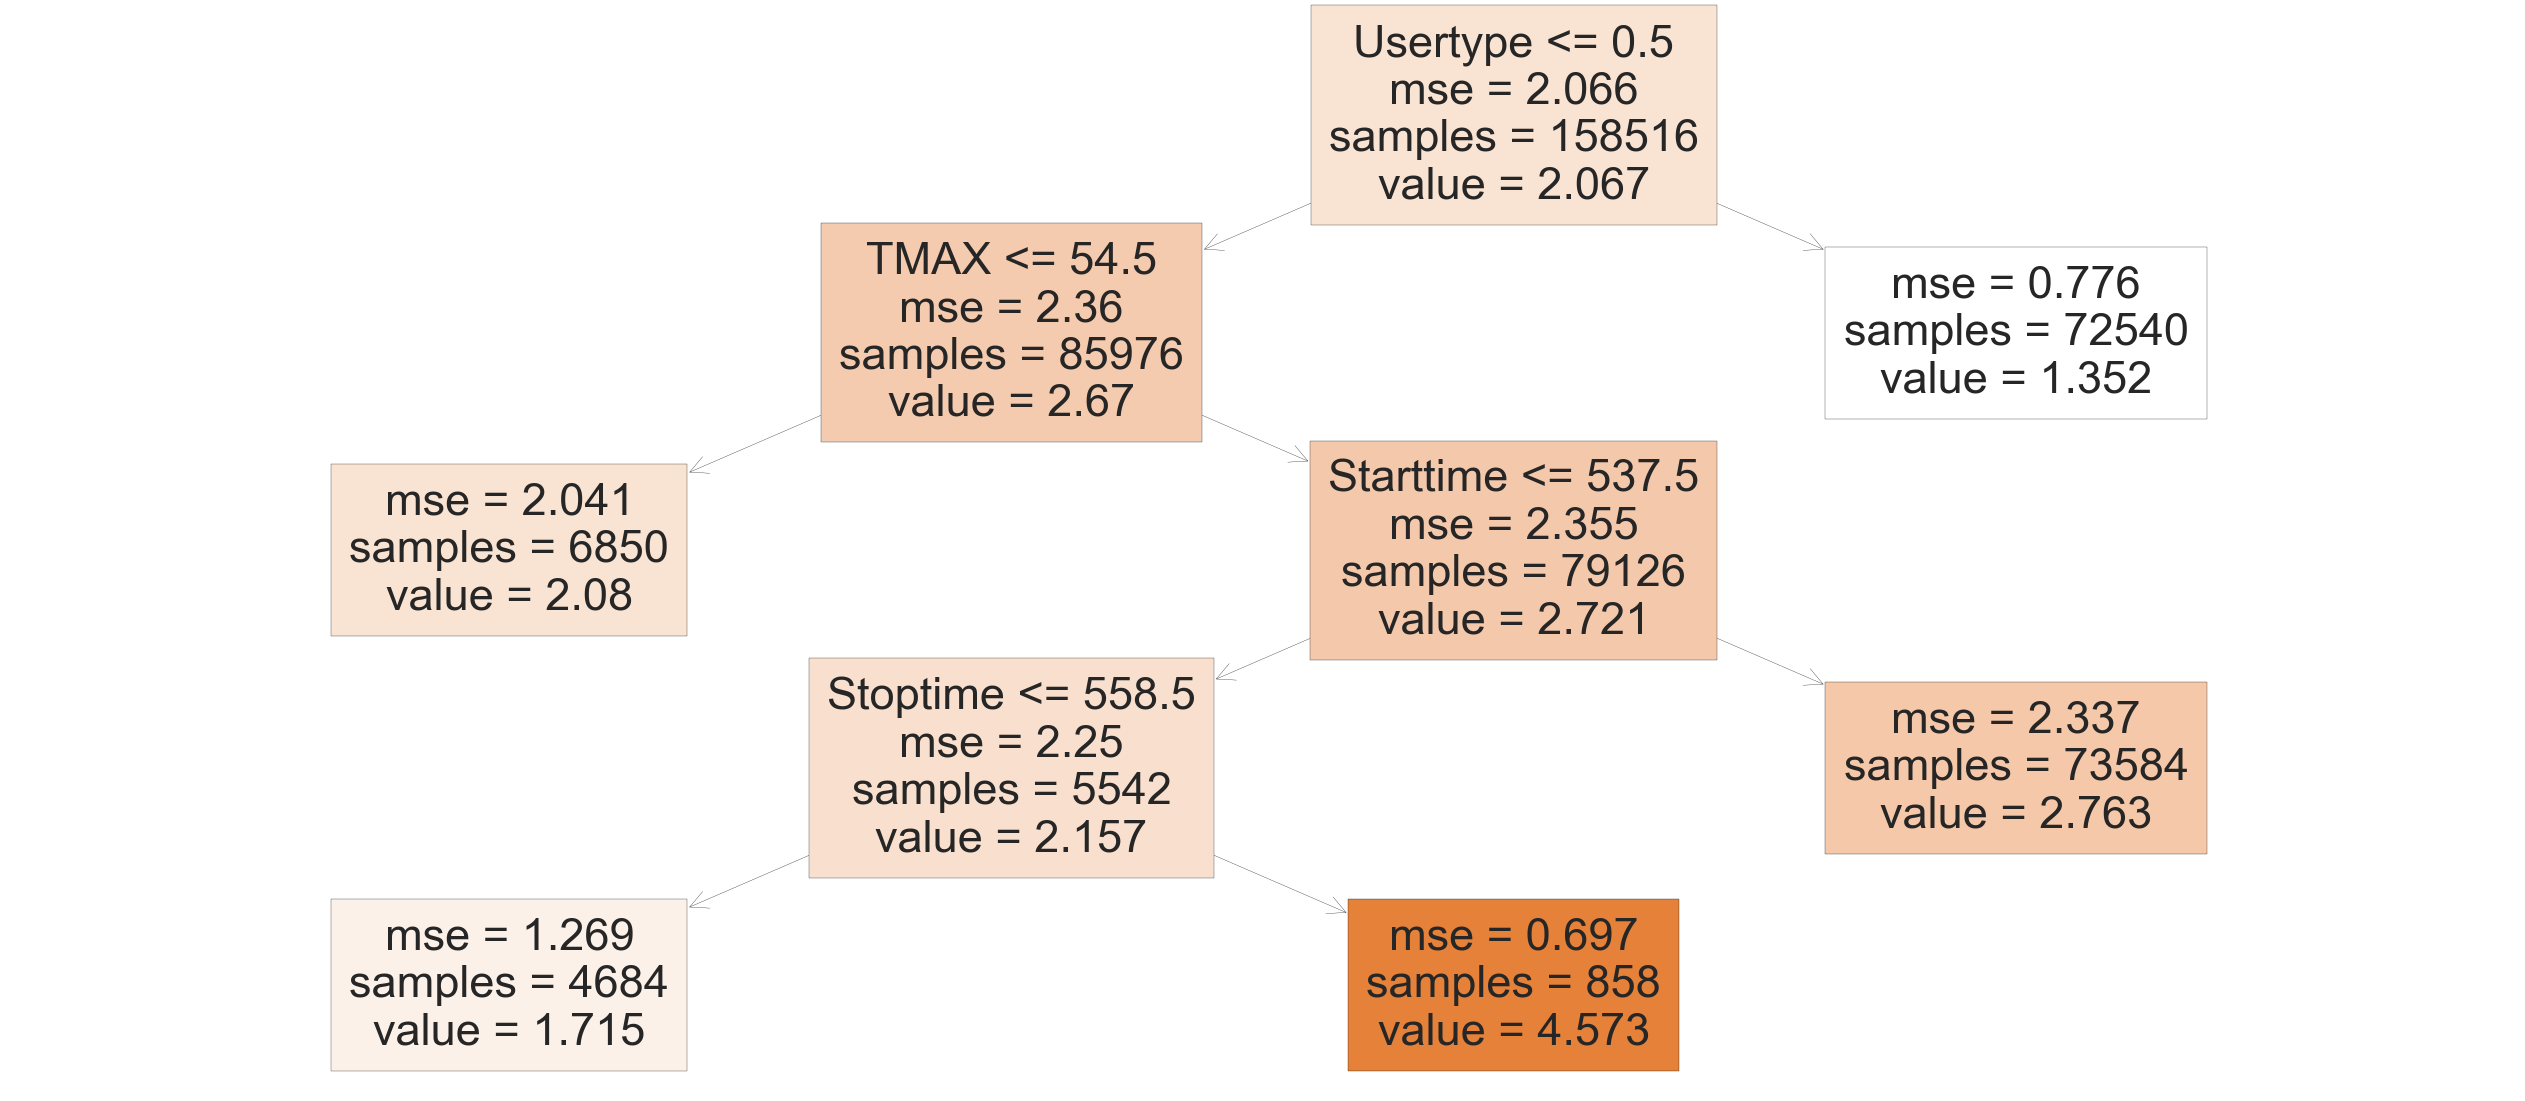

---------------------------------------------------------------------------


In [19]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # DecisionTree
    reg_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=1)
    reg_tree.fit(X_train_q1, y_train_q1)

    # print the result of the tree and cross validation
    print("Time interval for duration is: " + str(i) + " seconds")
    cv_scores = cross_val_score(reg_tree, X_train_q1, y_train_q1, cv=10, scoring='r2')
    print("Mean CV score of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))

    cv_scores = cross_val_score(reg_tree, X_train_q1, y_train_q1, cv=10,scoring='neg_mean_squared_error')
    print("Mean CV score of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))
    
    test_score = reg_tree.score(X_test_q1,y_test_q1)
    print("Accuracy of test dataset is: " + str(test_score))
    
    # Plot the generated tree
    fig = plt.figure(figsize=(45,20))
    plot_tree = tree.plot_tree(reg_tree, 
                       feature_names=X_q1.columns,  
                       filled=True)
    plt.show()
    
    print("---------------------------------------------------------------------------")

Decision Tree is the worst model for the problem, with accuracy only around 0.3.

Model 4: Random Forest

In [20]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 

Due to the data quantity, we train the model with 10-50 trees and try to get the best number of trees.

Time interval for duration is: 600 seconds
The best number of trees is: 40


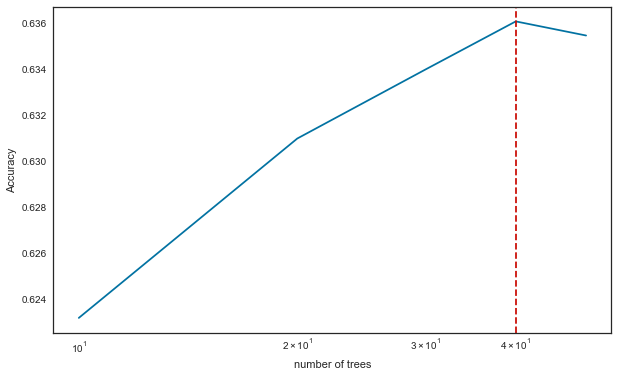

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
The best number of trees is: 50


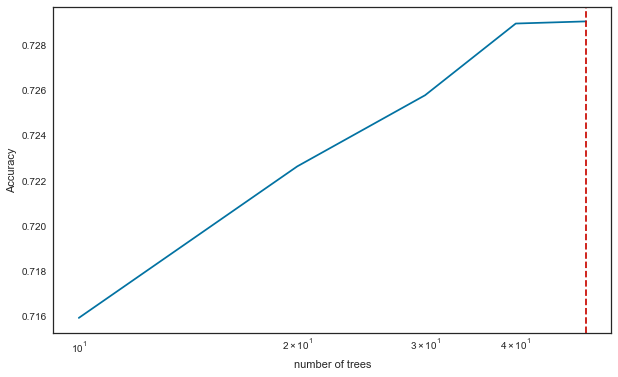

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
The best number of trees is: 50


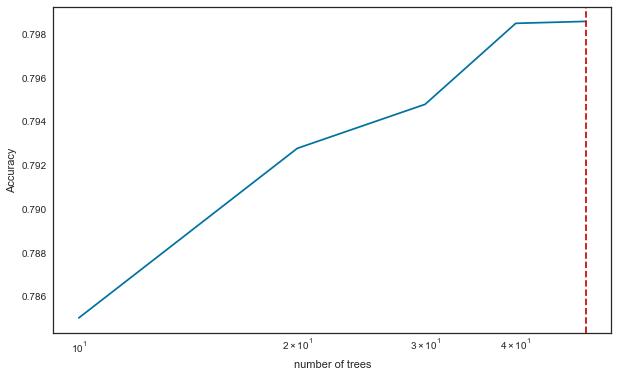

---------------------------------------------------------------------------


In [26]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # try from 10 to 50 trees with the step size = 10
    trees = range(10, 60, 10)
    # CV_score
    score = []

    for j in trees:
        # Build a RandomForestClassifier
        rf = RandomForestClassifier(random_state=0, n_estimators = j)
        rf.fit(X_train_q1, y_train_q1)
        # calculate the accuracy
        CV_error = np.mean(cross_val_score(rf, X_train_q1, y_train_q1, cv=10, scoring='accuracy'))
        score.append(CV_error)

    print("Time interval for duration is: " + str(i) + " seconds")
    # the best number of trees
    print("The best number of trees is: " + str(trees[score.index(max(score))]))

    # plot the relationship between tree and accuracy
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.plot(trees, score)
    plt.axvline(x=trees[score.index(max(score))], color='r', linestyle='--')
    ax.set_xscale('log')
    plt.xlabel('number of trees')
    plt.ylabel('Accuracy')
    plt.axis('tight')
    plt.show()

    print("---------------------------------------------------------------------------")

Now we use the best number of trees to tune the model.

In [28]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50
    
    # Build a RandomForestClassifier
    rf = RandomForestClassifier(random_state=0, n_estimators = j)
    rf.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    # the best number of trees
    print("The best number of trees is: " + str(j))

    # performance of prediction
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
The best number of trees is: 40
              precision    recall  f1-score   support

           1       0.60      0.67      0.63     19797
           2       0.48      0.51      0.49     16831
           3       0.48      0.39      0.43      7752
           4       0.57      0.40      0.47      4433
           5       0.91      0.91      0.91     19123

    accuracy                           0.65     67936
   macro avg       0.61      0.57      0.59     67936
weighted avg       0.65      0.65      0.64     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
The best number of trees is: 50
              precision    recall  f1-score   support

           1       0.76      0.87      0.81     30155
           2       0.55      0.48      0.51     14225
           3       0.60      0.49      0.54      6203
           4       0.68      0.55      0.61      4403
           5  

Then, we use GridSearchCV to tune two parameters(min_samples_leaf and min_samples_split) of the model after determining the best number of trees.

In [34]:
# try min_samples_leaf

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50
    
    # try parameter min_samples_leaf from 5 to 51 with the step size = 5
    parameters = {'min_samples_leaf':range(5, 51, 5)}

    # remember to control the random_state = 0 to compare to each other
    rf = RandomForestClassifier(random_state=0, n_estimators = j)

    # train the model
    rf_tuned = GridSearchCV(rf, parameters, scoring = 'accuracy')
    rf_tuned.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    
    # print the scores and the best params
    print(rf_tuned.cv_results_['mean_test_score'])
    print(rf_tuned.best_params_)

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_leaf = rf_tuned.best_params_['min_samples_leaf'])
    rf.fit(X_train_q1, y_train_q1)

    # print the classification_report
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
[0.62495901 0.6014093  0.58141135 0.56675672 0.55866918 0.54715617
 0.53957962 0.53408491 0.52656514 0.52467891]
{'min_samples_leaf': 5}
              precision    recall  f1-score   support

           1       0.59      0.76      0.66     19797
           2       0.49      0.48      0.48     16831
           3       0.55      0.24      0.33      7752
           4       0.62      0.18      0.27      4433
           5       0.81      0.92      0.86     19123

    accuracy                           0.64     67936
   macro avg       0.61      0.51      0.52     67936
weighted avg       0.62      0.64      0.61     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
[0.71322138 0.69046662 0.67389409 0.66249465 0.65402868 0.64377098
 0.63891973 0.63269952 0.6294128  0.62811958]
{'min_samples_leaf': 5}
              precision    recall  f1-score   support

           1       0

In [36]:
# try min_samples_split

# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50
    
    # try parameter min_samples_split from 5 to 51 with the step size = 5
    parameters = {'min_samples_split':range(5, 51, 5)}

    # remember to control the random_state = 0 to compare to each other
    rf = RandomForestClassifier(random_state=0, n_estimators = j)

    # train the model
    rf_tuned = GridSearchCV(rf, parameters, scoring = 'accuracy')
    rf_tuned.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    
    # print the scores and the best params
    print(rf_tuned.cv_results_['mean_test_score'])
    print(rf_tuned.best_params_)

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_split = rf_tuned.best_params_['min_samples_split'])
    rf.fit(X_train_q1, y_train_q1)

    # print the classification_report
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
[0.63817534 0.6334187  0.62656132 0.62302231 0.61113074 0.60278459
 0.60054506 0.59698713 0.59459613 0.58313988]
{'min_samples_split': 5}
              precision    recall  f1-score   support

           1       0.61      0.71      0.66     19797
           2       0.50      0.52      0.51     16831
           3       0.53      0.36      0.43      7752
           4       0.61      0.35      0.45      4433
           5       0.89      0.92      0.90     19123

    accuracy                           0.66     67936
   macro avg       0.63      0.57      0.59     67936
weighted avg       0.65      0.66      0.65     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
[0.72790127 0.72484166 0.71625573 0.71449573 0.70717784 0.69656691
 0.69061798 0.68733124 0.68672566 0.67805773]
{'min_samples_split': 5}
              precision    recall  f1-score   support

           1      

Compared to the result tuned with the best number of trees, the result of 'min_samples_leaf' is a little bit worse and the result of 'min_samples_split' is a little bit better.

Then we plot the importance of features with the best model we got.

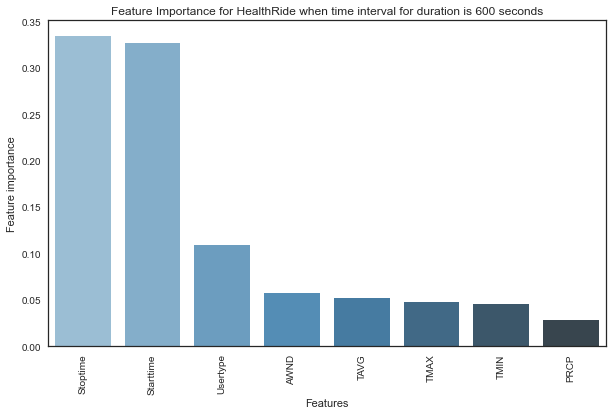

---------------------------------------------------------------------------


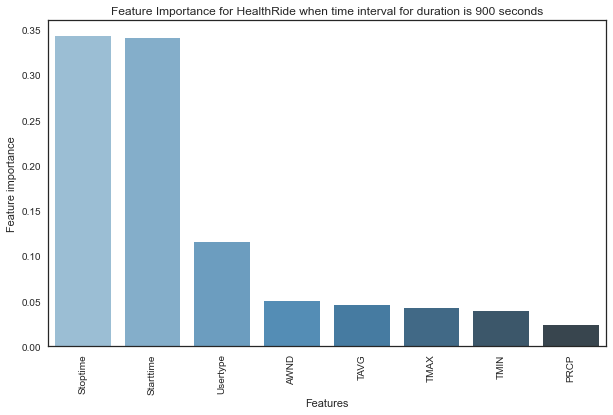

---------------------------------------------------------------------------


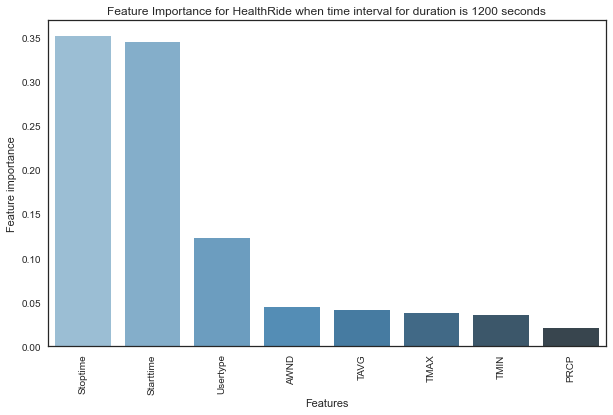

---------------------------------------------------------------------------


In [41]:
# plot the importance of features with best min_samples_split = 5

# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1d['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_split = 5)
    rf.fit(X_train_q1, y_train_q1)

    plt.figure(figsize=(10, 6))
    forest_importances = pd.DataFrame({ 'features': X_q1.columns, 'importances': rf.feature_importances_ })
    sns.barplot(x="features",y="importances" ,data=forest_importances, 
                order=forest_importances.sort_values('importances',ascending = False).features, palette="Blues_d")
    plt.xticks(rotation=90)
    plt.title("Feature Importance for HealthRide when time interval for duration is " + str(i) + " seconds")
    plt.ylabel("Feature importance")
    plt.xlabel("Features")
    plt.show()

    print("---------------------------------------------------------------------------")

From the figures, it is obvious that 'Stoptime' and 'Starttime' are most important features; 'Usertype' is also important.

Model Comparison: 

For the 4 models, KNN and Random Forest are the best two models, with the accuracy 0.9 and 0.8; Naive Bayes and Decision Tree are not suitable models for this problem.

In terms of step size of Tripduration, the larger the step size is, the better the performance of model is.


Conclusions and Suggestions:

More than 50% of people usually ride for less than 20 minutes in one trip, and about 20% of people can ride for 30-40 minutes. The rest of them ride for longer time and some of them forget to return the bikes.

In order to better serve the customers, we suggest HealthRide set a station in every 15 minute-ride. In this way, when people feel tired to ride, they can easily find a nearby station to return the bike.
In addition, HealthyRide may consider setting time recording system: when the bike is in use for over 1 hour, it can give out a alert to remind the user of returning the bike.
